In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

In [2]:
#instantiate a holistic model for pose estimation
mp_holistic = mp.solutions.holistic
#create variable to enable drawing utilities (drawing landmarks)
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
#model refers to the mediapipe model, in this case holstic
#because holistic is going to be a full pose estimation (as opposed to
#just an estimation of the hand movement given sign language does not only
#include movement in the hand itself)
def mediapipe_detection(image, model):
    #opencv reads in data as BGR but you need it to be RGB for work with mediapipe
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #set to false to increase performance
    image.flags.writeable = False
    #make the prediction
    results = model.process(image)
    #set to true after you make the prediction
    image.flags.writeable = True 
    #set colors back to be opencv-friendly
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_landmarks(image, results):
    #X_CONNECTIONS is essentially the mapping (i.e., your eyes is next to your nose,
    #your nose is next to your mouth, etc.)
    mp_drawing.draw_landmarks(image, results.face_landmarks, 
                              mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, 
                              mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, 
                              mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, 
                              mp_holistic.HAND_CONNECTIONS)

#### Only run code below to test the opencv/webcam aspect

In [4]:
#make sure we can access the webcam with opencv
cap = cv2.VideoCapture(0)
#declare the model and parameters that will be used in while loop for video feedback
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #read the feed, frame is the image from the webcam
        ret, frame = cap.read()

        #make the detections
        image, results = mediapipe_detection(frame, holistic)
        
        #draw the results of the detections
        draw_landmarks(image, results)

        #grab the current frame and show it (they're stacked together so its a video)
        cv2.imshow('OpenCV Feed', image)

        #create way to end the process
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    #not exactly sure why this works but adding waitKey allows the program to close
    #successfully!
    cv2.waitKey(1)

INTERSTING POINT: If there is no hand or face in the frame of the video, landmarks will return an error because a lack of those body parts returns a NoneType

In [5]:
len(results.right_hand_landmarks.landmark)

21

In [6]:
results

mediapipe.python.solution_base.SolutionOutputs

In [7]:
draw_landmarks(frame, results)

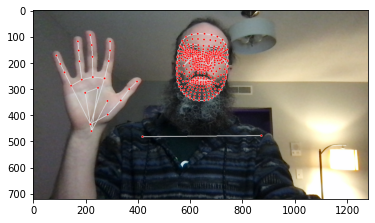

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [4]:
#function to extract the keypoints from the training data
def extract_keypoints(results):
    lh_array = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
    rh_array = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)
    pose_array = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face_array = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    
    return np.concatenate([pose_array, face_array, lh_array, rh_array])

### Collect the data and organize

In [5]:
#where to store the data
DATA_PATH = os.path.join('MP_Data') 

#signs to detect
signs = np.array(['Hello', 'How are you?', 'See you later!'])

#number of videos per sign
num_sequences = 30

#number of frames per video
num_frames = 30

### The code immediately below is used to collect the training data through the webcam. Leave commented out unless you plan on running it!

In [6]:
# #set up folder structure to save the data
# for sign in signs: 
#     for sequence in range(num_sequences):
#         try: 
#             os.makedirs(os.path.join(DATA_PATH, sign, str(sequence)))
#         except:
#             pass

In [7]:
# #make sure we can access the webcam with opencv
# cap = cv2.VideoCapture(0)
# #declare the model and parameters that will be used in while loop for video feedback
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
#     for sign in signs:
#         # Loop through sequences (which are actually the videos)
#         for sequence in range(num_sequences):
#             # Loop through video length aka sequence length
#             for frame_num in range(num_frames):

#                 #read the feed, frame is the image from the webcam
#                 ret, frame = cap.read()

#                 #make the detections
#                 image, results = mediapipe_detection(frame, holistic)

#                 #draw the results of the detections
#                 draw_landmarks(image, results)
                
#                 #set up breaks between videos to get ready
#                 if frame_num == 0: 
#                     cv2.putText(image, 'START SIGN', (120, 200),
#                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 225, 0), 2, cv2.LINE_AA)
#                     cv2.putText(image, 'Collecting frames for {}, Video Number {}'.format(sign, sequence),
#                                (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2, cv2.LINE_AA)
#                     cv2.imshow('OpenCV Feed', image)
#                     #2 second break
#                     cv2.waitKey(2000)
#                 else: 
#                     cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(sign, sequence), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     cv2.imshow('OpenCV Feed', image)
                
#                 #extract keypoints
#                 keypoints = extract_keypoints(results)
#                 numpy_path = os.path.join(DATA_PATH, sign, str(sequence), str(frame_num))
#                 np.save(numpy_path, keypoints)

#                 #create way to end the process
#                 if cv2.waitKey(10) & 0xFF == ord('q'):
#                     break
                    
#     cap.release()
#     cv2.destroyAllWindows()
#     cv2.waitKey(1)

### Building the neural network was done in Google Colab. I am leaving the code in this notebook. If you want to see the code run in Google Colab, please see Sign_Language_Detection_Colab.ipynb in the project folder.

In [8]:
#create a mapping of signs to numbers to use as labels
label_map = {label:num for num, label in enumerate(signs)}

In [9]:
label_map

{'Hello': 0, 'How are you?': 1, 'See you later!': 2}

In [10]:
#sequences will be ultimate by X and labels will be y
sequences, labels = [], []
#loop through the various signs
for sign in signs:
    #loop through each sequence (video)
    for sequence in range(num_sequences):
        #set up variable to store all of the frames for a given video
        window = []
        #loop through every frame for video
        for frame_num in range(num_frames):
            #load the frame's numpy array and save it
            res = np.load(os.path.join(DATA_PATH, sign, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        #add window (collection of video's frame arrays) and add it to X data variable
        sequences.append(window)
        labels.append(label_map[sign])

In [11]:
#this means there are 90 videos, 30 frames per video, and 1662 keypoints per frame
np.array(sequences).shape

(90, 30, 1662)

In [12]:
#90 labels for our 90 videos
np.array(labels).shape

(90,)

In [13]:
#convert sequences from list to a numpy array
X = np.array(sequences)
X.shape

(90, 30, 1662)

In [14]:
#one hot encoding for the labels
y = to_categorical(labels).astype(int)

y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [15]:
#split the data for 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [16]:
y_test.shape

(18, 3)

In [17]:
y_train.shape

(72, 3)

In [18]:
#commented this out so I do not accidentally run it!

# model = Sequential()
# model.add(GRU(30, return_sequences=True, activation='relu', input_shape=(30,1662), dropout = 0.1))
# model.add(GRU(20, return_sequences=True, activation='relu', dropout = 0.1))
# model.add(GRU(10, return_sequences=False, activation='relu', dropout = 0.1))
# model.add(Dense(10, activation='relu'))
# model.add(Dense(5, activation='relu'))
# model.add(Dense(signs.shape[0], activation='softmax'))

# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
#commented this out so I do not accidentally run it!

# history = model.fit(X_train, y_train, epochs=50, batch_size = 8, validation_data = (X_test, y_test))

In [20]:
#commented this out so I do not accidentally run it!

# _, acc = model.evaluate(X_test, y_test)

In [21]:
#commented this out so I do not accidentally run it!

# acc

In [22]:
#commented this out so I do not accidentally run it!

# plt.title('Cross Entropy Loss')
# plt.plot(history.history['loss'], color='blue', label='train')
# plt.plot(history.history['val_loss'], color='orange', label='test')

In [23]:
# commented this out so I do not accidentally run it!

# plt.title('Classification Accuracy')
# plt.plot(history.history['accuracy'], color='blue', label='train')
# plt.plot(history.history['val_accuracy'], color='orange', label='test')

In [24]:
#overall summary of the model
# model.summary()

In [25]:
# #this was run in Google Colab after training
# model.save('sign_language_detection.h5')

### END BLOCK OF GOOGLE COLAB CODE

### Since the model was trained in Google Colab, the saved weights are being loaded in this notebook in order to implement the sign language detection via webcam.

In [26]:
model = Sequential()
model.add(GRU(30, return_sequences=True, activation='relu', input_shape=(30,1662), dropout = 0.1))
model.add(GRU(20, return_sequences=True, activation='relu', dropout = 0.1))
model.add(GRU(10, return_sequences=False, activation='relu', dropout = 0.1))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(signs.shape[0], activation='softmax'))


model.load_weights('sign_language_detection.h5')

### Analyze the performance accuracy of the model

In [27]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [28]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[10,  0],
        [ 0,  8]],

       [[12,  0],
        [ 0,  6]],

       [[14,  0],
        [ 0,  4]]])

In [29]:
accuracy_score(ytrue, yhat)

1.0

### It is worth pointing out the somewhat "unrealistic" accuracy score for the model. Keep in mind that there are only 90 training samples. With that, the "perfect score" makes more sense.

In [32]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, signs, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, signs[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [33]:
#save 30 frames which will ultimately be passed to model for comparison
sequence = []
#concat the past predictions
predictions = []
sentence = []
threshold = 0.6

#make sure we can access the webcam with opencv
cap = cv2.VideoCapture(0)
#declare the model and parameters that will be used in while loop for video feedback
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        #read the feed, frame is the image from the webcam
        ret, frame = cap.read()

        #make the detections
        image, results = mediapipe_detection(frame, holistic)
        
        #draw the results of the detections
        draw_landmarks(image, results)
        
        #make the predictions
        keypoints = extract_keypoints(results)
        #sequence.insert(0,keypoints)
        #sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            
            
        #add a visualization
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if signs[np.argmax(res)] != sentence[-1]:
                            sentence.append(signs[np.argmax(res)])
                    else:
                        sentence.append(signs[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, signs, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [31]:
cap.release()
cv2.destroyAllWindows()